In [1]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download NLTK data if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Check if GPU is available, and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the pre-trained BERT model and tokenizer on the selected device
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)


In [5]:
# Function to remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    text_without_punct = text.translate(translator)
    return text_without_punct

# Function to lowercase text
def lowercase_text(text):
    return text.lower()

# Function to remove stop words
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.cpu().tolist()  # Move embeddings back to CPU


In [6]:
# Read the CSV file
data = pd.read_csv('thesis.csv', encoding='latin-1')


In [8]:
# Merge the 'Title' and 'Abstract' columns into a single column called 'Text'
data['Text'] = data['title'].fillna('') + ' ' + data['abstract'].fillna('')


In [9]:
# Function to preprocess text
def preprocess_text(text):
    # Add more preprocessing steps as needed
    text = remove_punctuation(text)
    text = lowercase_text(text)
    text = remove_stop_words(text)
    return text

# Apply the preprocessing function to the 'Text' column before calling preprocess_and_get_embeddings
data['Text'] = data['Text'].apply(preprocess_text)

def preprocess_and_get_embeddings(row):
    text = row['Text']
    embeddings = get_bert_embeddings(text)
    return pd.Series({'Text_Embeddings': embeddings})

# Apply the preprocessing and embedding function to each row of the DataFrame
embeddings_data = data.apply(preprocess_and_get_embeddings, axis=1)


In [10]:

# Concatenate the embeddings with the original DataFrame
data = pd.concat([data, embeddings_data], axis=1)

# Reshape the text embeddings to 2D
text_embeddings = np.array(data['Text_Embeddings'].tolist())


In [11]:
# Check the shape of text_embeddings
print(text_embeddings.shape)  # Should be (number_of_samples, embedding_dimension)


(1212, 1, 768)


In [12]:
# Standardize the embeddings
scaler = StandardScaler()
text_embeddings_reshaped = text_embeddings.reshape(text_embeddings.shape[0], -1)
text_embeddings_scaled = scaler.fit_transform(text_embeddings_reshaped)

# Reduce dimensionality with PCA for efficiency
pca = PCA(n_components=0.95)  # Retain 95% of the variance
text_embeddings_pca = pca.fit_transform(text_embeddings_scaled)

# Define the hierarchical_clustering function
def hierarchical_clustering(data, max_d, text_embeddings_pca):
    # Use linkage and fcluster from scipy for hierarchical clustering
    Z = linkage(text_embeddings_pca, method='ward')
    text_cluster_labels = fcluster(Z, max_d, criterion='distance')

    # Add cluster labels to the DataFrame for text embeddings
    data['Text_Cluster'] = text_cluster_labels
    
    return data

# Hyperparameter tuning
max_d_values = [1.0, 2.0, 3.0]  # Try different values of max_d

for max_d in max_d_values:
    clustered_data = hierarchical_clustering(data.copy(), max_d, text_embeddings_pca)

    # Evaluate and visualize the clusters (you can add this part)


In [13]:
# Use linkage and fcluster from scipy for hierarchical clustering
Z = linkage(text_embeddings_pca, method='ward')
max_d = 2  # You can adjust this threshold as needed
text_cluster_labels = fcluster(Z, max_d, criterion='distance')



# Add cluster labels to the DataFrame for text embeddings
data['Text_Cluster'] = text_cluster_labels

# Save the DataFrame with embeddings and clusters to a new CSV file
data.to_csv('cluster_Data_thesis.csv', index=False)

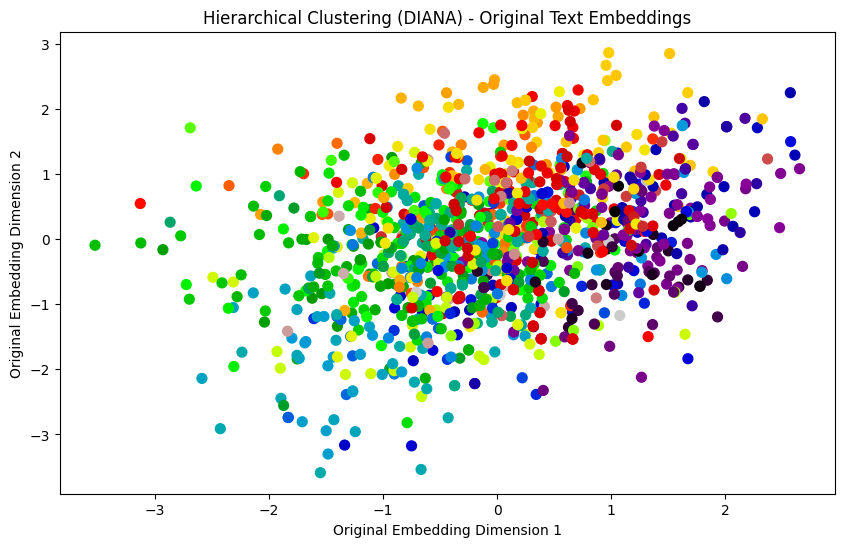

In [22]:
# Create a scatter plot to visualize clusters without PCA
plt.figure(figsize=(10, 6))

# Get the maximum cluster label
max_cluster_label = max(clustered_data['Text_Cluster'])

# Normalize cluster labels between 0 and 1
normalized_labels = clustered_data['Text_Cluster'] / max_cluster_label

# Use normalized_labels for coloring
colors = plt.cm.nipy_spectral(normalized_labels)

plt.scatter(text_embeddings_scaled[:, 0], text_embeddings_scaled[:, 1], c=colors, marker='o', s=50)
plt.title('Hierarchical Clustering (DIANA) - Original Text Embeddings')
plt.xlabel('Original Embedding Dimension 1')
plt.ylabel('Original Embedding Dimension 2')
plt.show()

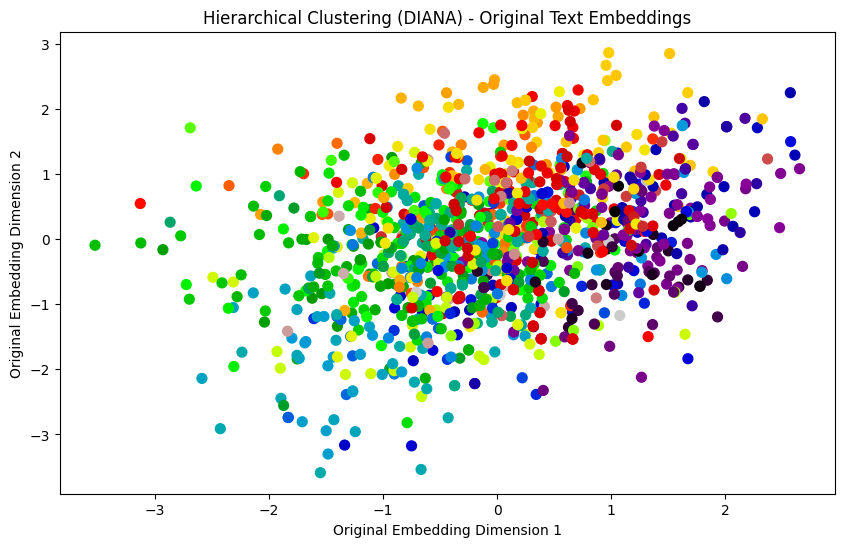

In [23]:
# Create a scatter plot to visualize clusters without PCA
plt.figure(figsize=(10, 6))
colors = plt.cm.nipy_spectral(data['Text_Cluster'].astype(float) / max(data['Text_Cluster']))
plt.scatter(text_embeddings_scaled[:, 0], text_embeddings_scaled[:, 1], c=colors, marker='o', s=50)
plt.title('Hierarchical Clustering (DIANA) - Original Text Embeddings')
plt.xlabel('Original Embedding Dimension 1')
plt.ylabel('Original Embedding Dimension 2')
plt.show()


In [15]:
# Assuming text_cluster_labels contains the cluster labels
max_cluster_label = max(text_cluster_labels)
num_clusters = max_cluster_label

print(f"Number of clusters: {num_clusters}")

Number of clusters: 1102


In [16]:
# Check the unique cluster labels in the 'Text_Cluster' column
unique_labels = clustered_data['Text_Cluster'].unique()

# Print the unique cluster labels
print("Unique Cluster Labels:")
print(unique_labels)


Unique Cluster Labels:
[221 265 271 ... 224 202 300]


Cluster Label Distribution:
Text_Cluster
407     3
154     3
272     3
1001    3
127     3
       ..
956     1
993     1
915     1
888     1
300     1
Name: count, Length: 1102, dtype: int64


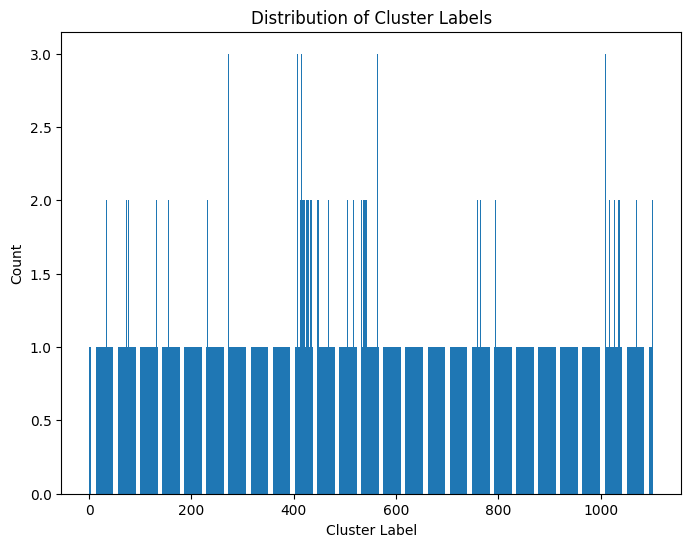

In [17]:
# Count occurrences of each cluster label
cluster_counts = clustered_data['Text_Cluster'].value_counts()

# Print the distribution of cluster labels
print("Cluster Label Distribution:")
print(cluster_counts)

# Visualize the distribution using a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.title('Distribution of Cluster Labels')
plt.show()


In [18]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for the clustered data
silhouette_avg = silhouette_score(text_embeddings_scaled, clustered_data['Text_Cluster'])

# Print the silhouette score
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.1699669939909032


In [20]:
print(clustered_data[['title', 'abstract', 'Text_Cluster']].head(10))


                                               title  \
0  PEMBUATAN VIDEO MOTION GRAPHIC TENTANG PERSALI...   
1  PEMANFAATAN 3D LAYER DAN EXPRESSIONS UNTUK PRO...   
2  PEMBUATAN FILM ANIMASI 2D âIMAGINEâ\r\nDEN...   
3  PENERAPAN METODE INVERS KINEMATIK DENGAN TEKNO...   
4  PEMBUATAN ANIMASI  PEMBELAJARAN METAMORFOSIS K...   
5  PERANCANGAN FILM ANIMASI 2D DENGAN TEKNIK FRAM...   
6  PEMBUATAN VIDEO KONTEN ANIMASI NOMINASI MUSIC ...   
7  PERANCANGAN SCENE ANIMASI 2D UNTUK\r\nMENGHASI...   
8  PERANCANGAN DAN PEMBUATAN ANIMASI 2D \r\nâTH...   
9  PEMBUATAN ANIMASI 2D CERITA RAKYAT âGUNUNG B...   

                                            abstract  Text_Cluster  
0  Animasi 2D, Persalinan Sehat,  2D, Motion grap...           221  
1  3D Layer, expressions, 2D, Kepala, Adobe After...           265  
2  animasi 2D, teknik frame by frame, teknik comp...           271  
3  Duik, invers kinematik, animasi 2D, non-humano...           266  
4  Animasi, Metamorfosis Kupu-kupu, SD

In [21]:
sample_texts = data['Text'].sample(5)  # Get a random sample of 5 texts
for text in sample_texts:
    print(text)

analisis dan perancangan sistem hotspot voucher berbasis mikhmon menggunakan mikrotik rb951ui hotspot sistem voucher mikhmon qos
pembuatan gerakan tari piring 2d menggunakan teknik rotoscoping live shot tari piring multimedia animasi rotoscoping
sistem pakar diagnosa penyakit sapi menggunakan metode certainty factor berbasis web sistem pakar certainty factor sapi
perancangan dan pembuatan aplikasi play yard berbasis android aplikasi android teknologi pembelajaran waterfall play yard
analisis dan perancangan media informasi dan komunikasi desa somongari berbasis website website code igniter pemerintah white box testing black box testing
